In [2]:
# Вариант 6
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, sqrtm
from scipy.special import hermite, factorial
from scipy.integrate import quad
from scipy.stats import chi2, chisquare
from scipy import interpolate
from tqdm import tqdm

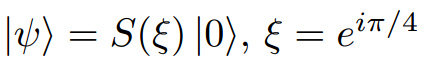

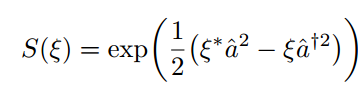

In [3]:
# генерирует чистое состояние
def gen_psi(d, k):
    c = np.random.randn(d*k) + 1j*np.random.randn(d*k)
    c = c/((abs(c)**2).sum()**0.5)
    return c

In [4]:
n_very_big = 1000

# Операторы уничтожения и рождения в конечномерном пространстве
A = np.zeros((n_very_big+1, n_very_big+1), dtype=complex)
A[:-1, 1:] = np.diag([i**0.5 for i in range(1, n_very_big+1)])
AH = np.conj(A.T)

# Оператор сжатия
xi = np.exp(1j*np.pi/4)
S = expm(1/2*(np.conj(xi)*A@A - xi*AH@AH))

vac_state = np.zeros(n_very_big+1)
vac_state[0] = 1

psi = S @ vac_state

n_max = n_very_big 
eps = 1e-6

while np.sum(abs(psi[n_max:])**2) < eps:
    n_max -= 1

psi = psi[:n_max+1]
ns = np.arange(n_max+1)

In [5]:
print('максимальное число фотонов: ' + str(n_max))

максимальное число фотонов: 44


In [6]:
psi

array([ 8.05018182e-01-6.93889390e-18j,  0.00000000e+00+0.00000000e+00j,
       -3.06548571e-01-3.06548571e-01j,  0.00000000e+00+0.00000000e+00j,
        2.77555756e-17+2.85935797e-01j,  0.00000000e+00+0.00000000e+00j,
        1.40568015e-01-1.40568015e-01j,  0.00000000e+00+0.00000000e+00j,
       -1.41621483e-01-3.12250226e-17j,  0.00000000e+00+0.00000000e+00j,
        7.23534090e-02+7.23534090e-02j,  0.00000000e+00+0.00000000e+00j,
        5.16080234e-17-7.46110786e-02j,  0.00000000e+00+0.00000000e+00j,
       -3.87185943e-02+3.87185943e-02j,  0.00000000e+00+0.00000000e+00j,
        4.03779086e-02+2.25514052e-17j,  0.00000000e+00+0.00000000e+00j,
       -2.11320015e-02-2.11320015e-02j,  0.00000000e+00+0.00000000e+00j,
       -1.10588622e-17+2.21840603e-02j,  0.00000000e+00+0.00000000e+00j,
        1.16720718e-02-1.16720718e-02j,  0.00000000e+00+0.00000000e+00j,
       -1.23067916e-02-8.34835673e-18j,  0.00000000e+00+0.00000000e+00j,
        6.49885403e-03+6.49885403e-03j,  0.00000000

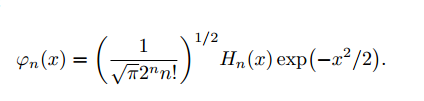

In [5]:
def phi(n, x):
    return (1/(np.pi**0.5*2**n*factorial(n)))**0.5*hermite(n)(x)*np.exp(-x**2/2)

def psi_theta(x, theta, psi):
    return np.sum(np.array([psi[n] * phi(n, x)*np.exp(1j*n*theta) for n in range(n_max + 1)]), axis=0)

def p(x, theta, psi):
    return abs(psi_theta(x, theta, psi))**2

# Более быстрая функция для вероятности. Понадобится при решении УП
def p_(phi_theta, psi):
    return abs(np.tensordot(psi, phi_theta, axes=1))**2

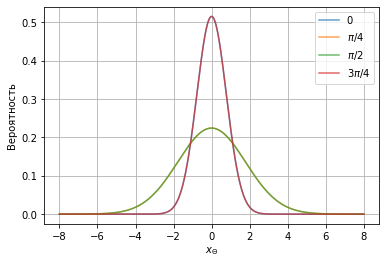

In [6]:
x = np.linspace(-8, 8, 10000)
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_literal = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']
for i in range(len(thetas)):
    plt.plot(x, p(x, thetas[i], psi), '-', alpha=0.7, label=thetas_literal[i])
plt.xlabel('$x_\Theta$')
plt.ylabel('Вероятность')
plt.legend()
plt.grid()
plt.show()

In [7]:
# Функция распределения вероятности
# Подсчет через trapz менее точен, чем quad (различие в 4 знаке), но сильно быстрее
def F(x, theta, psi):
    return np.cumsum(p(x, theta, psi)*(x[1]-x[0]))

In [8]:
# Сгенерируем выборку
n = 10000
xs_all = np.zeros((len(thetas), n))
thetas_all = np.reshape(thetas*n, (n, len(thetas))).T

for j in range(len(thetas)):
    y = F(x, thetas[j], psi)
    F_inv = interpolate.interp1d(y, x, fill_value=(0, 1), bounds_error=False)
    gamma = np.random.rand(n)
    xs_all[j] = F_inv(gamma)

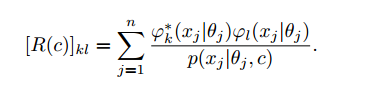

In [9]:
%%time
# Создадим матрицу R
phi_theta = np.array([phi(n, xs_all)*np.exp(1j*n*thetas_all) for n in range(n_max + 1)])
phi_matrix = np.array([[np.conj(phi(k, xs_all)*np.exp(1j*k*thetas_all))*\
            phi(l, xs_all)*np.exp(1j*l*thetas_all) for l in range(n_max+1)] for k in range(n_max+1)])
                                      
def R(xs_all, thetas_all, psi):
    ps = p_(phi_theta, psi)
    return np.tensordot(phi_matrix, 1/ps, axes=2)

Wall time: 22.2 s


In [10]:
%%time
# Будем решать УП итерационно с регуляризацией
eps = 1e-8
mu=0.5
psi_rec = gen_psi(n_max+1, 1)
psi_old = np.zeros_like(psi_rec)

while(np.sum(abs(psi_rec - psi_old)**2)**0.5 > eps):
    psi_old = psi_rec
    psi_rec = (1-mu)*R(xs_all, thetas_all, psi_old) @ psi_old / np.prod(xs_all.shape) + mu*psi_old

Wall time: 18.1 s


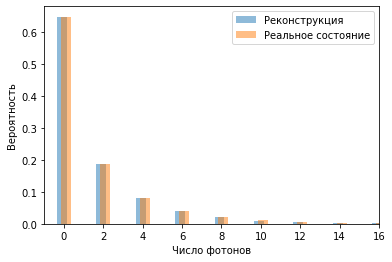

In [11]:
plt.bar(ns-0.1, abs(psi_rec)**2, alpha=0.5, width=0.5, label='Реконструкция')
plt.bar(ns+0.1, abs(psi)**2, alpha=0.5, width=0.5, label='Реальное состояние')
plt.xticks(ns[0::2], labels=None)
plt.xlim(-1, 16)
plt.xlabel('Число фотонов')
plt.ylabel('Вероятность')
plt.legend()
plt.show()

In [12]:
# Фиделити
fidelity = abs(psi @ np.conj(psi_rec))
print('F = ' + str(fidelity))

F = 0.9992301186136856


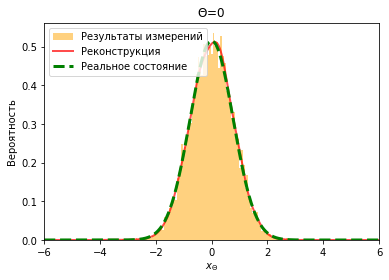

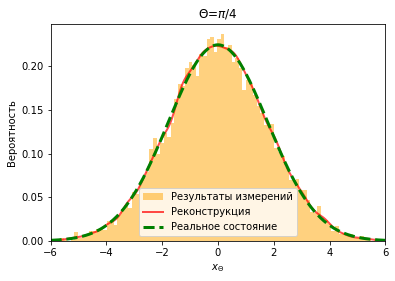

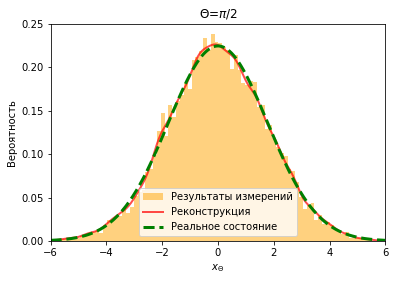

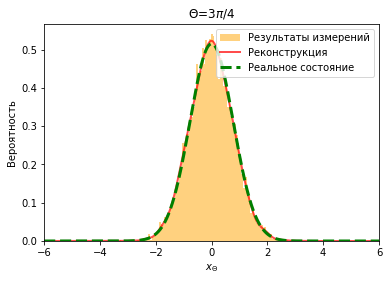

In [13]:
for i in range(len(thetas)):    
    plt.hist(xs_all[i], bins=100, density=True, alpha=0.5, color='orange', label='Результаты измерений')
    plt.plot(x, p(x, thetas[i], psi_rec), '-', lw=2, alpha=0.7, color='red', label='Реконструкция')
    plt.plot(x, p(x, thetas[i], psi), '--', lw=3, color='green', label='Реальное состояние')
    plt.xlabel('$x_\Theta$')
    plt.ylabel('Вероятность')
    plt.xlim(-6, 6)
    plt.legend()
    plt.title('$\Theta$='+str(thetas_literal[i]))
    plt.show()

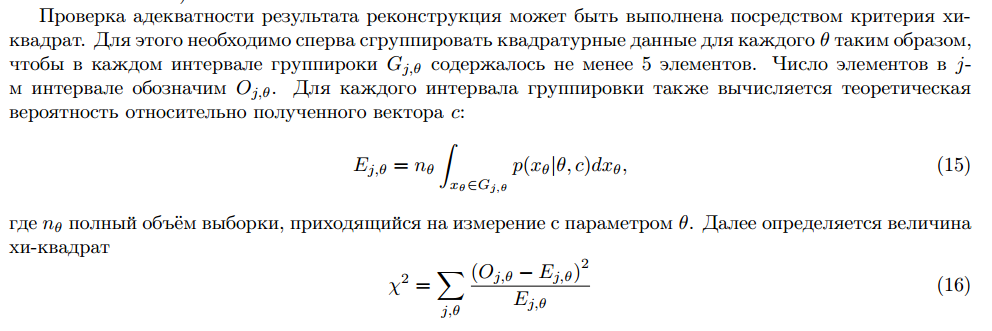

In [14]:
M = 1000
Ms = np.zeros(len(thetas))
chi2_value = 0
for i in range(len(thetas)):
    bins=np.quantile(xs_all[i], np.linspace(0,1,M+1))
    O, G = np.histogram(xs_all[i], bins=M)
    F_ = interpolate.interp1d(x, F(x, thetas[i], psi_rec), fill_value=(0, 1), bounds_error=False)
    
    G[0], G[-1] = -10, 10 
    FG = n*F_(G)
    E = FG[1:] - FG[:-1]
    
    chi2_value += np.sum((O - E)**2/E)

In [15]:
nu = 4*M - len(thetas) - (2*n_max+2)
p_value = 1 - chi2.cdf(chi2_value, nu)
print('p-value = ' + str(p_value))

p-value = 0.8009399968068989
